# __DICODING MACHINE LEARNING__
Nama : Fahmy Rosyadi <br>
Asal Instansi : Politeknik Negeri Jember
<br>
Proyek : Emotion Classification Model Deployment

In [2]:
import os, cv2, itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

In [52]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Bidirectional, MaxPooling2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.optimizers import Adam

Dataset :

*   kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
*   kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset



## Load Dataset dari Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

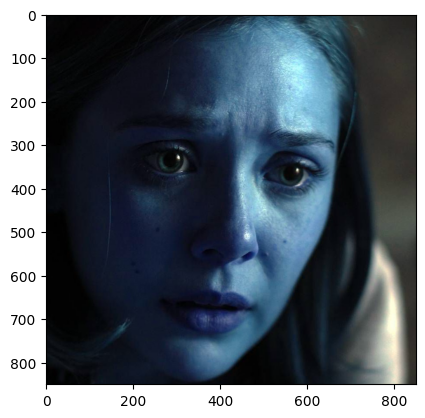

In [10]:
test = cv2.imread('/content/drive/MyDrive/DatasetCollab/FaceEmotion/Sad/000c70df36933106e44c1d1bd5e4221f86bdb040d9d5659c3d083606.jpg')
plt.imshow(test)

In [11]:
def show_dataset(images_class, label):
    if images_class is None or any(img is None for img in images_class):
        print(f"Error: images_class contains None for label {label}")
        return

    plt.figure(figsize=(14, 5))
    for i in range(1, 6):
        plt.subplot(1, 5, i)
        try:
            if len(images_class[i - 1].shape) == 3:
                plt.imshow(images_class[i - 1][:, :, ::-1])
            else:
                plt.imshow(images_class[i - 1], cmap='gray')
            plt.title(label)
            plt.axis('off')
            plt.tight_layout()
        except (IndexError, TypeError) as e:
            print(f"Error displaying image: {e}")
            break
    plt.show()


## Pelabelan

In [12]:
dataset_folder = "/content/drive/MyDrive/DatasetCollab/FaceEmotion/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    for name in os.listdir(os.path.join(dataset_folder, folder)):
        if any(name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif', '.JPG', '.tiff']):
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            images.append(img)
            names.append(folder)

In [13]:
labels = np.unique(names)

labels

array(['Sad', 'happy', 'neutral'], dtype='<U7')

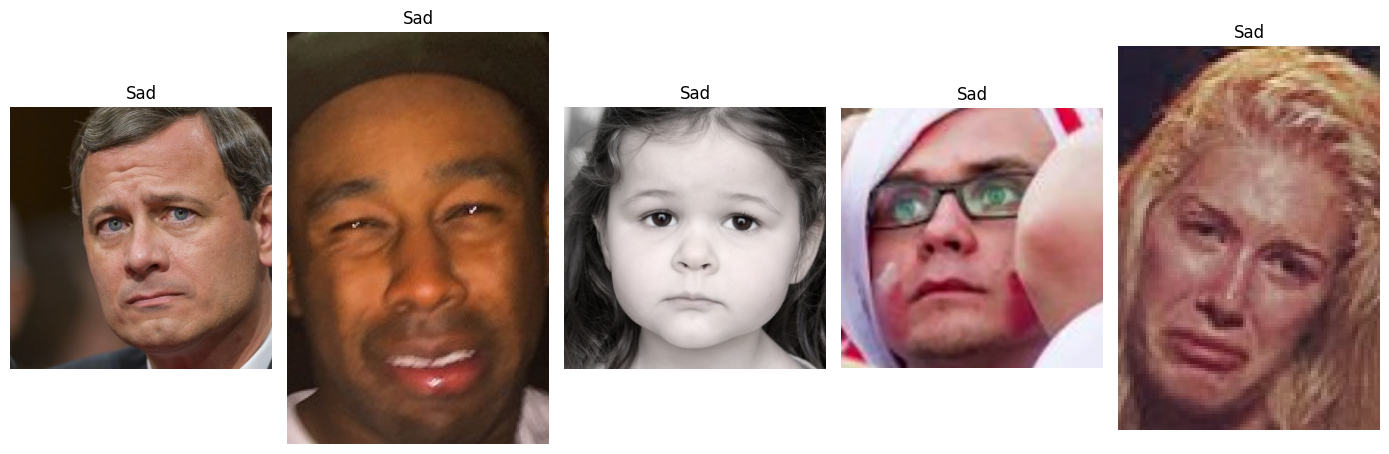

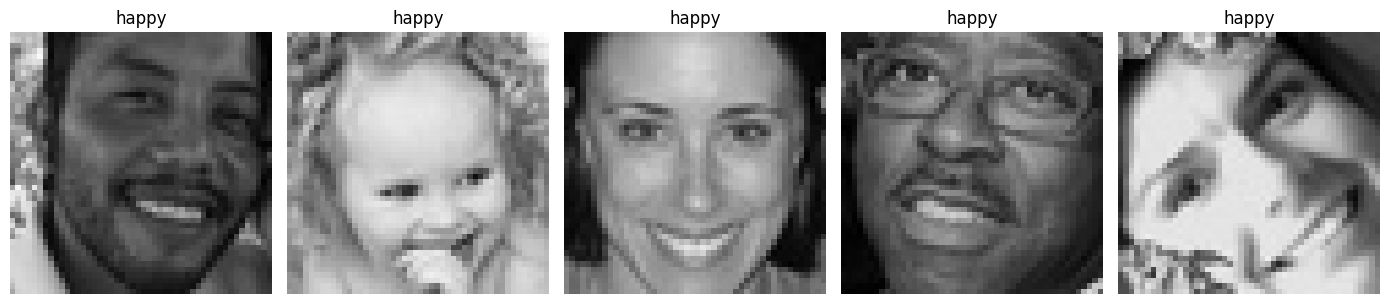

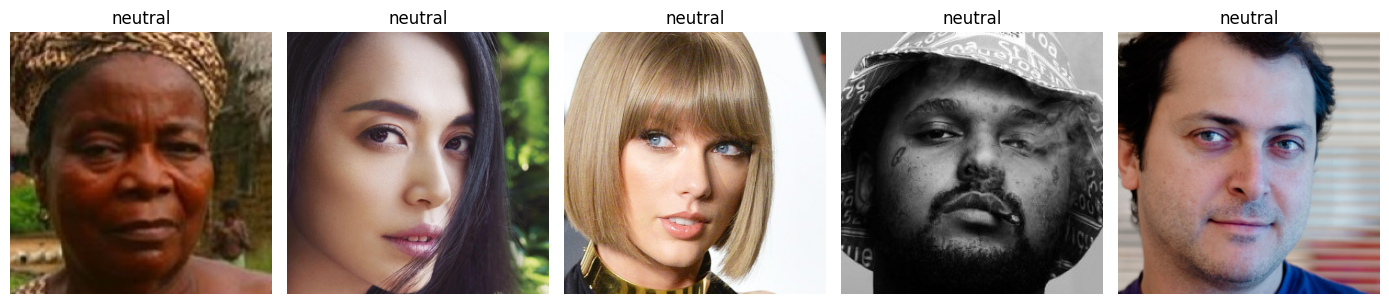

In [14]:
for label in labels:

    ids = np.where(label== np.array(names))[0]
    images_class = images[ids[0] : ids[-1] + 1]
    show_dataset(images_class, label)

In [15]:
print("Total Dataset : ",len(images))

Total Dataset :  12191


## Preprocessing Dataset

In [17]:
def detect_face(img, idx):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/DatasetCollab/Haarcascade/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    try:
        x, y, w, h = faces[0]
    except IndexError:
        h, w = img_gray.shape
        center_x, center_y = w // 2, h // 2
        crop_size = 200
        x = max(center_x - crop_size // 2, 0)
        y = max(center_y - crop_size // 2, 0)
        w = crop_size
        h = crop_size
    img_cropped = img_gray[y:y+h, x:x+w]
    img_resized = cv2.resize(img_cropped, (50, 50))
    return img_resized

In [18]:
cropped_images = []

for i, img in enumerate(images):
    cropped_img = detect_face(img, i)
    if cropped_img is not None:
        cropped_images.append(cropped_img)

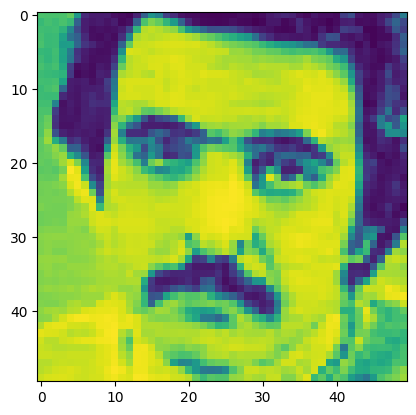

In [24]:
plt.imshow(cropped_images[170])

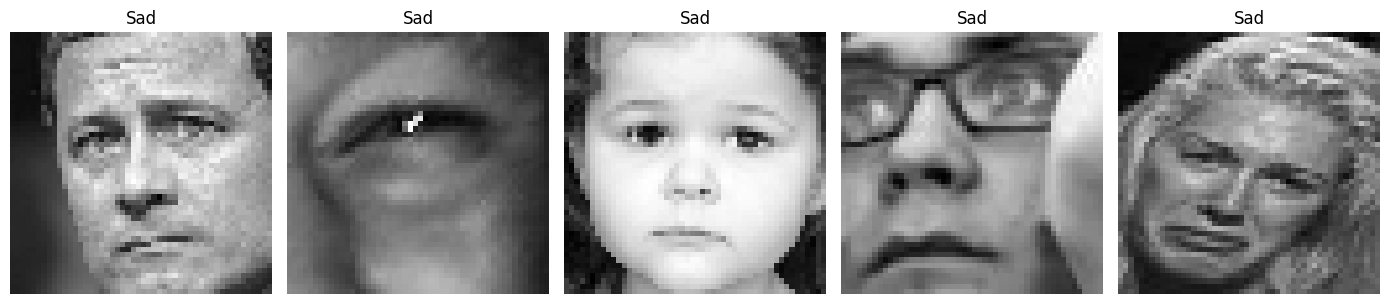

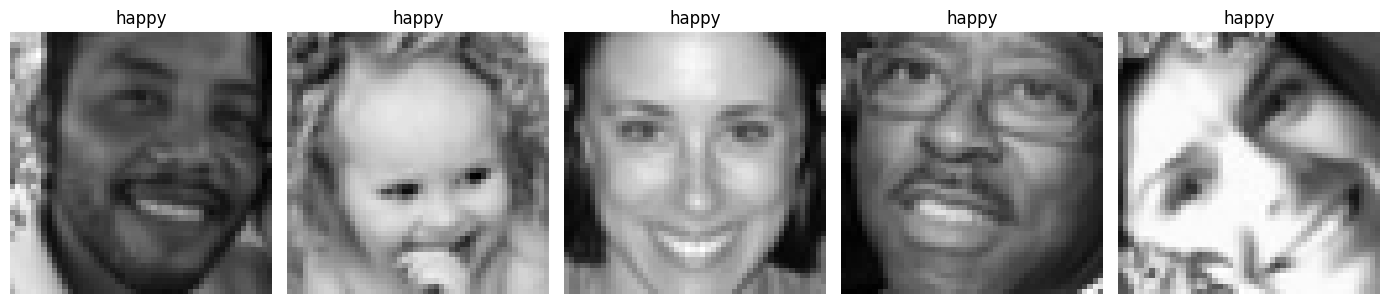

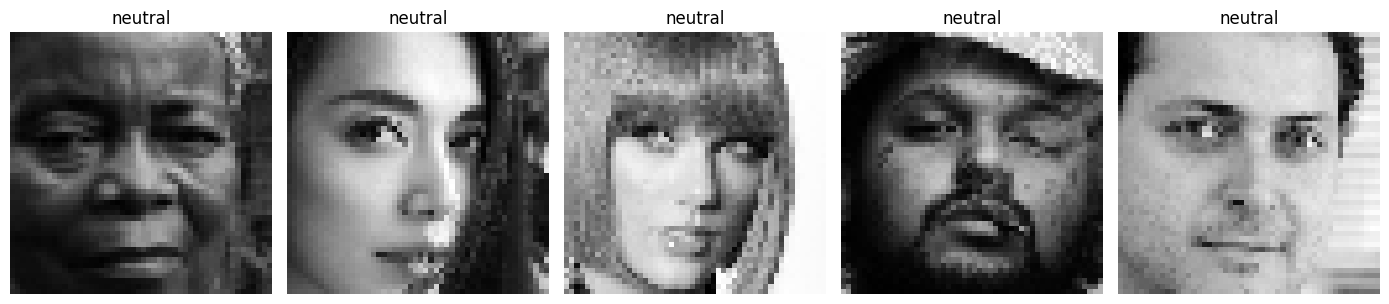

In [25]:
for label in labels:

    ids = np.where(label== np.array(names))[0]
    images_class = cropped_images[ids[0] : ids[-1] + 1]
    show_dataset(images_class, label)

In [26]:
cropped_images[8].shape

(50, 50)

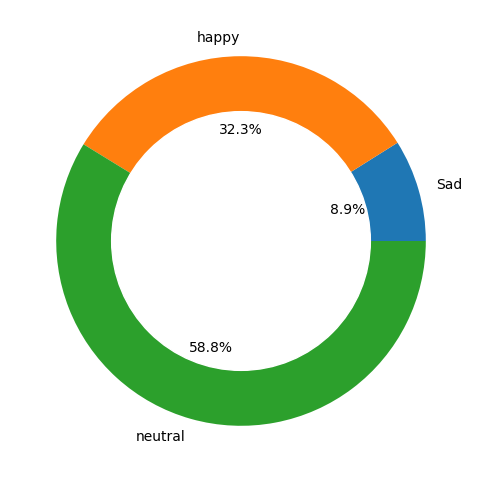

In [27]:
def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()

unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [28]:
len(names)

12191

## Encoding Labels

In [29]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [30]:
print("number of class :", len(labels))
print(labels)

number of class : 3
['Sad' 'happy' 'neutral']


In [31]:
print(name_vec)

[2 2 2 ... 1 1 1]


In [32]:
print(categorical_name_vec)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


## Split Dataset 80 : 20 Train and validation

In [33]:
x_train, x_test, y_train, y_test = train_test_split(np.array(cropped_images, dtype=np.float32),
                                                    np.array(categorical_name_vec),
                                                    test_size=0.2,
                                                    random_state=42)

In [34]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(9752, 50, 50) (9752, 3) (2439, 50, 50) (2439, 3)


In [35]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [36]:
x_train.shape, x_test.shape

((9752, 50, 50, 1), (2439, 50, 50, 1))

## Augmentasi Gambar

In [37]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

data_train = train_datagen.flow(x_train, y_train, batch_size=128, seed=42)

data_test = test_datagen.flow(x_test, y_test, batch_size=128, seed=42)

## Make Model

In [53]:
def cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512,
                    (3,3),
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())


    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))
    model.add(Activation("softmax"))
    model.summary()

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

In [54]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [55]:
input_shape = x_train[0].shape

EPOCHS = 100
BATCH_SIZE = 128

model = cnn_model(input_shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 22, 22, 128)      

In [56]:
import tensorflow as tf
tf.device('/device:GPU:0')
history = model.fit(data_train,
                    epochs = EPOCHS,
                    steps_per_epoch = data_train.n // data_train.batch_size,
                    validation_data = data_test,
                    validation_steps = data_test.n // data_test.batch_size,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/100
76/76 - 9s - loss: 0.9890 - accuracy: 0.5759 - val_loss: 0.9646 - val_accuracy: 0.6049 - 9s/epoch - 123ms/step
Epoch 2/100
76/76 - 7s - loss: 0.7119 - accuracy: 0.7040 - val_loss: 1.7493 - val_accuracy: 0.3310 - 7s/epoch - 91ms/step
Epoch 3/100
76/76 - 6s - loss: 0.5829 - accuracy: 0.7764 - val_loss: 2.6733 - val_accuracy: 0.3306 - 6s/epoch - 73ms/step
Epoch 4/100
76/76 - 7s - loss: 0.4886 - accuracy: 0.8094 - val_loss: 3.9359 - val_accuracy: 0.3310 - 7s/epoch - 90ms/step
Epoch 5/100
76/76 - 6s - loss: 0.4276 - accuracy: 0.8350 - val_loss: 4.8197 - val_accuracy: 0.3306 - 6s/epoch - 74ms/step
Epoch 6/100
76/76 - 7s - loss: 0.3991 - accuracy: 0.8485 - val_loss: 3.3678 - val_accuracy: 0.3331 - 7s/epoch - 87ms/step
Epoch 7/100
76/76 - 9s - loss: 0.3811 - accuracy: 0.8535 - val_loss: 0.5597 - val_accuracy: 0.7652 - 9s/epoch - 118ms/step
Epoch 8/100
76/76 - 6s - loss: 0.3666 - accuracy: 0.8588 - val_loss: 3.5283 - val_accuracy: 0.3310 - 6s/epoch - 73ms/step
Epoch 9/100
76/76 - 7s

## Evaluated Model

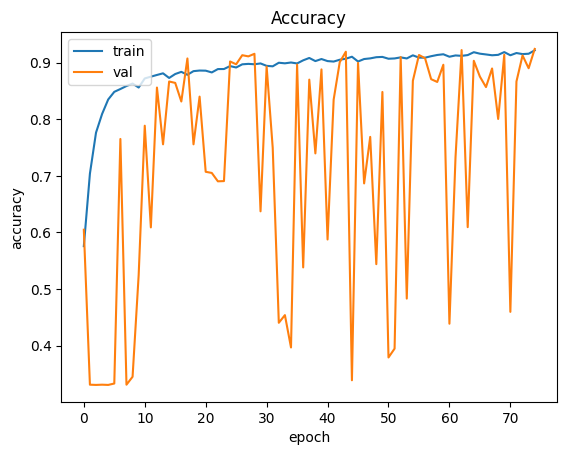

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

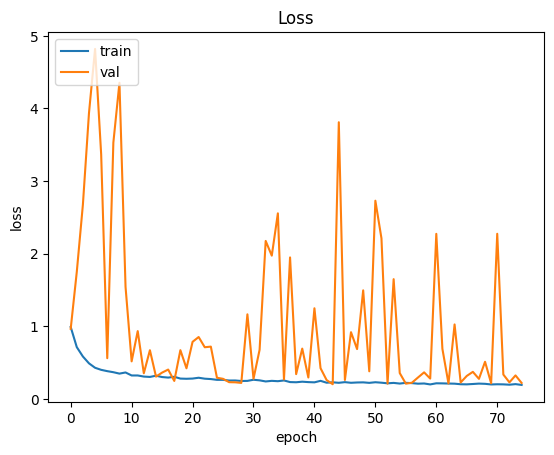

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Deploy Model

In [60]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [61]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root 6503852 Jan 24 22:22 model.tflite
